# FlyHomes Data Challenge: Kaggle Zillow Prize
### Brian Henn - September 2018 

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from scipy.stats import randint

In [3]:
# define filename and paths
fname_features_2016 = './data/properties_2016.csv'
fname_features_2017 = './data/properties_2017.csv'
fname_sales_2016 = './data/train_2016_v2.csv'
fname_sales_2017 = './data/train_2017.csv'
fname_sub = './data/output_submission.csv'

In [4]:
# load 2016 and 2017 sales data
sales_2016 = pd.read_csv(fname_sales_2016, index_col=0, header=0, 
                         parse_dates=[2], infer_datetime_format=True)
sales_2017 = pd.read_csv(fname_sales_2017, index_col=0, header=0, 
                         parse_dates=[2], infer_datetime_format=True)
sales = pd.concat([sales_2016, sales_2017])
sales_set = sales.index.unique().values
print(sales.head(5))

          logerror transactiondate
parcelid                          
11016594    0.0276      2016-01-01
14366692   -0.1684      2016-01-01
12098116   -0.0040      2016-01-01
12643413    0.0218      2016-01-02
14432541   -0.0050      2016-01-02


In [5]:
# inner join 2016 and 2017 feature data with sales data on parcel id

# first, load 2016 feature data, grabbing only the rows with sales data for memory purposes
iter_csv = pd.read_csv(fname_features_2016, index_col=0, header=0, iterator=True, chunksize=50000)
features_2016 = pd.concat([chunk[chunk.index.isin(sales_set)] for chunk in iter_csv])

# now, join the feature data to the sales data, duplicating properties with multiple sales
features_2016_with_sales = features_2016.merge(sales, left_index=True, right_index=True)

/home/brian/anaconda3/envs/insight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/brian/anaconda3/envs/insight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/brian/anaconda3/envs/insight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (22,49) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/brian/anaconda3/envs/insight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Fraction of rows with at least one missing value: 1.0000.



Text(0.5,1,'Fraction of Missing Data')

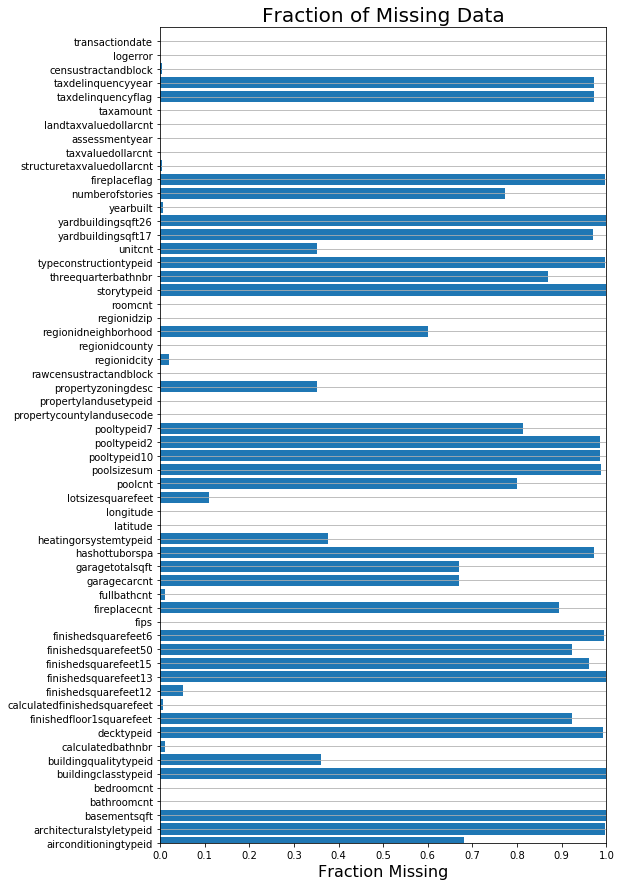

In [6]:
frac_at_least_one_missing = sum(features_2016_with_sales.isnull().sum(1) > 0)/len(features_2016_with_sales)
print('Fraction of rows with at least one missing value: %0.4f.\n' % (frac_at_least_one_missing))

frac_missing = []
for col in features_2016_with_sales.columns.values:
    frac_missing.append((len(features_2016_with_sales[col]) - features_2016_with_sales[col].count())/len(
        features_2016_with_sales[col]))
    
fig = plt.figure()
fig.set_size_inches([8,15])
ax = fig.subplots()
ax.barh(range(len(frac_missing)), frac_missing)
ax.set_xlim([0,1]) 
ax.set_xlabel('Fraction Missing', fontsize=16)
ax.set_ylim([0,len(frac_missing)])
ax.set_xticks(np.arange(0,1.01,0.1))
ax.set_yticks(range(len(frac_missing)))
ax.set_yticklabels(features_2016_with_sales.columns.values,rotation = 0);
ax.grid(True,'major','y')
ax.set_title('Fraction of Missing Data', fontsize=20)

In [7]:
# reduce features to those with at least 75% of data

features_2016_with_sales = features_2016_with_sales.iloc[:,[frac < 0.25 for frac in frac_missing]]
frac_missing = [frac_missing[i] for i, _ in enumerate(frac_missing) if frac_missing[i] < 0.25]

In [8]:
print(features_2016_with_sales.shape)
print(features_2016_with_sales.columns)
print(features_2016_with_sales['propertylandusetypeid'].value_counts())

(167888, 26)
Index(['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'propertylandusetypeid',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'logerror', 'transactiondate'],
      dtype='object')
261.0    112994
266.0     42143
246.0      4422
269.0      4291
248.0      1594
247.0      1167
265.0       691
263.0       158
275.0       105
260.0        92
267.0        58
31.0         32
264.0        16
47.0          1
Name: propertylandusetypeid, dtype: int64


In [9]:
features_2016_with_sales.iloc[:,:20].sample(15)

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt
parcelid,,,,,,,,,,,,,,,,,,,,
17266787,2.0,3.0,2.0,1046.0,1046.0,6111.0,2.0,34168259.0,-118937790.0,15246.0,1111,261.0,6.111006e+07,34278.0,2061.0,96351.0,5.0,1971.0,155394.0,258987.0
11215710,2.0,4.0,2.0,1360.0,1360.0,6037.0,2.0,34563594.0,-118019127.0,7023.0,0100,261.0,6.037911e+07,40227.0,3101.0,97330.0,0.0,1994.0,133017.0,166234.0
11062680,2.0,2.0,2.0,2317.0,2317.0,6037.0,2.0,34228126.0,-118505211.0,18927.0,0100,261.0,6.037115e+07,12447.0,3101.0,96355.0,0.0,1951.0,149300.0,601000.0
12547963,1.0,1.0,1.0,632.0,632.0,6037.0,1.0,33764400.0,-118171000.0,44381.0,010C,266.0,6.037577e+07,46298.0,3101.0,96236.0,0.0,1975.0,184418.0,312337.0
11089756,2.0,3.0,2.0,1886.0,1886.0,6037.0,2.0,34249351.0,-118565458.0,6998.0,0100,261.0,6.037113e+07,12447.0,3101.0,96346.0,0.0,1958.0,65868.0,89093.0
10848857,2.0,2.0,2.0,1392.0,1392.0,6037.0,2.0,34165200.0,-118467000.0,49288.0,010C,266.0,6.037129e+07,12447.0,3101.0,96412.0,0.0,1981.0,167779.0,223451.0
17297598,2.0,3.0,2.0,1689.0,1689.0,6111.0,2.0,34169621.0,-118750225.0,8516.0,1111,261.0,6.111007e+07,53655.0,2061.0,96393.0,6.0,1979.0,318944.0,637888.0
11164349,3.0,4.0,3.0,2192.0,2192.0,6037.0,3.0,34383250.0,-118552951.0,5829.0,0100,261.0,6.037920e+07,54311.0,3101.0,96378.0,0.0,1968.0,167122.0,364837.0
12758135,2.0,3.0,2.0,1660.0,1660.0,6037.0,2.0,33890713.0,-118098736.0,5155.0,0100,261.0,6.037553e+07,53636.0,3101.0,96193.0,0.0,1964.0,129851.0,226931.0


In [10]:
# transform categorical variable about property type into more useful set of dummy variables

# single family homes (most of the dataset)
features_2016_with_sales['single_family'] = [
    1 if val == 261.0 else 0 for val in features_2016_with_sales['propertylandusetypeid']]
# multi-family (duplex/triplex etc.)
features_2016_with_sales['multi_family'] = [
    1 if (val >= 246.0 and val <= 248.0) else 0 for val in features_2016_with_sales['propertylandusetypeid']]
# condos (a lot of these also)
features_2016_with_sales['condominium'] = [
    1 if val == 266.0 else 0 for val in features_2016_with_sales['propertylandusetypeid']]
# planned/cluster/mobile (a few of these)
features_2016_with_sales['planned_community'] = [
    1 if (val == 263.0 or val == 265.0 or val == 269.0) \
    else 0 for val in features_2016_with_sales['propertylandusetypeid']]
# everything else (small number of random unusual residential types and commercial properties)
features_2016_with_sales['other_property'] = [
    1 if val not in [246.0, 247.0, 248.0, 261.0, 263.0, 265.0, 266.0, 
        269.0] else 0 for val in features_2016_with_sales['propertylandusetypeid']]

#features_2016_with_sales[['propertylandusetypeid','single_family','multi_family','condominium']].sample(15)

In [11]:
# list useful features for inclusion in the model

features_in_model = ['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','fullbathcnt',
                     'latitude','longitude','lotsizesquarefeet','single_family','multi_family','condominium',
                    'planned_community','other_property','regionidzip','yearbuilt','taxvaluedollarcnt']

X = features_2016_with_sales[features_in_model]
X.sample(10)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,fullbathcnt,latitude,longitude,lotsizesquarefeet,single_family,multi_family,condominium,planned_community,other_property,regionidzip,yearbuilt,taxvaluedollarcnt
parcelid,,,,,,,,,,,,,,,
14040009,4.0,3.0,1774.0,3.0,33727938.0,-118032791.0,6188.0,1,0,0,0,0,96967.0,1960.0,586500.0
14730942,1.0,1.0,914.0,1.0,33658525.0,-117639444.0,NaN,0,0,1,0,0,96996.0,1993.0,302934.0
11630892,1.0,2.0,737.0,2.0,34074700.0,-118389000.0,90089.0,0,0,1,0,0,96029.0,1971.0,387979.0
11847769,6.0,5.0,2445.0,5.0,34049475.0,-118136430.0,7543.0,1,0,0,0,0,96496.0,1978.0,502381.0
10782458,3.0,2.0,1269.0,2.0,34188900.0,-118552000.0,351847.0,0,0,1,0,0,96364.0,1975.0,350000.0
14146680,3.0,2.0,1952.0,2.0,33902033.0,-117909643.0,8395.0,1,0,0,0,0,97043.0,1965.0,86426.0
14673626,2.0,2.0,1222.0,2.0,33409000.0,-117602000.0,NaN,0,0,1,0,0,96982.0,1976.0,392602.0
14330771,2.0,1.0,1080.0,1.0,33737405.0,-117812761.0,7300.0,1,0,0,0,0,97016.0,1927.0,31482.0
17123093,5.0,2.0,1916.0,2.0,34235976.0,-119050727.0,7490.0,1,0,0,0,0,97089.0,1965.0,539000.0


In [12]:
# impute missing values using sklearn's implementation

# impute using the mean as a simple solution
imputer = Imputer(strategy='mean')
X_imputed = X.copy()
for col in X.columns.values:
    if sum(X[col].isna()) > 0: # only apply this to columns with missing data
        imputer.fit(X[[col]])
        X_imputed[col] = imputer.transform(X[[col]]).ravel()

X_imputed.sample(20)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,fullbathcnt,latitude,longitude,lotsizesquarefeet,single_family,multi_family,condominium,planned_community,other_property,regionidzip,yearbuilt,taxvaluedollarcnt
parcelid,,,,,,,,,,,,,,,
11342199,2.0,1.0,870.0,1.0,34444200.0,-118509000.0,65885.000000,0,0,1,0,0,96373.0,1984.0,130636.0
10960923,3.0,2.0,1750.0,2.0,34163188.0,-118335246.0,5275.000000,1,0,0,0,0,96437.0,1986.0,339138.0
12446907,2.0,1.0,950.0,1.0,33876270.0,-118172445.0,6109.000000,1,0,0,0,0,96239.0,1943.0,240782.0
12537032,2.0,1.0,904.0,1.0,33764256.0,-118138786.0,5646.000000,0,0,1,0,0,96237.0,1955.0,335000.0
11607946,3.0,2.0,1741.0,2.0,34050400.0,-118414000.0,13004.000000,0,0,1,0,0,96045.0,1971.0,698000.0
10864129,1.0,1.0,630.0,1.0,34150300.0,-118468000.0,29517.306848,0,0,1,0,0,96412.0,1988.0,223936.0
17295517,2.0,2.0,1144.0,2.0,34146844.0,-118823347.0,2508.000000,0,0,0,1,0,96384.0,1973.0,476442.0
14494052,4.0,2.0,1916.0,2.0,33637462.0,-117648024.0,5959.000000,1,0,0,0,0,96995.0,1977.0,311003.0
11454427,3.0,3.0,2926.0,3.0,33981504.0,-118380714.0,10087.000000,1,0,0,0,0,96037.0,1961.0,518708.0


In [13]:
# get sales data as training dataset

Y = features_2016_with_sales[['logerror','transactiondate']]
Y.sample(15)

,logerror,transactiondate
parcelid,,
14622599,0.032874,2017-08-04
14609570,0.005952,2017-08-28
11043060,0.030263,2017-01-30
10847477,-0.004000,2016-05-25
11154539,0.000000,2016-06-10
12922515,0.022370,2017-06-20
12642223,-0.005000,2016-06-24
12940589,-0.059800,2016-10-03
12014394,-0.049200,2016-07-26


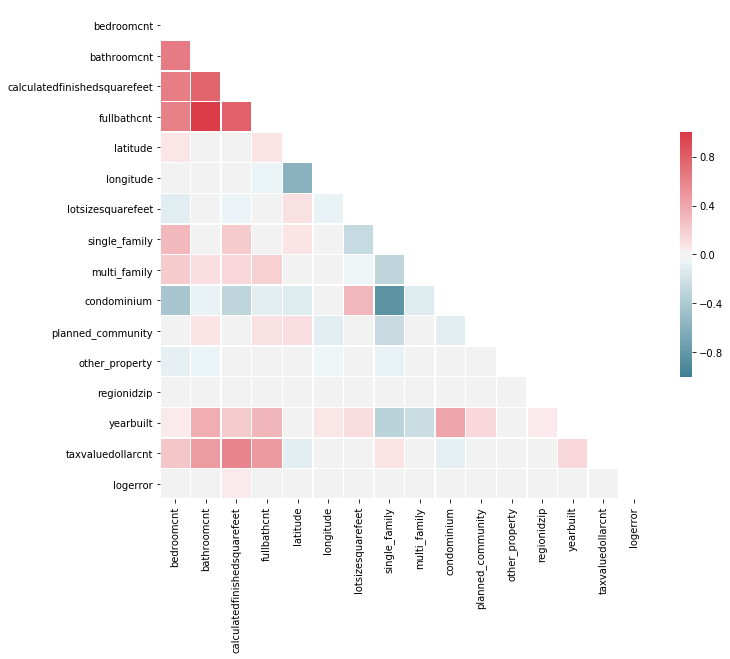

In [14]:
# examine the correlations among the selected features and with the log error

# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# set up colormap for correlation plots
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmax = 1
cmin = -1

# create a dataframe of just the features we want to look at, plus the target)
plot_columns = features_in_model
plot_columns.append('logerror')
full_df = features_2016_with_sales[plot_columns]
                                                    
# Compute the correlation matrix
corr_properties = full_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_properties, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_properties, mask=mask, cmap=cmap, vmax=cmax, vmin=cmin, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

(16, 16)


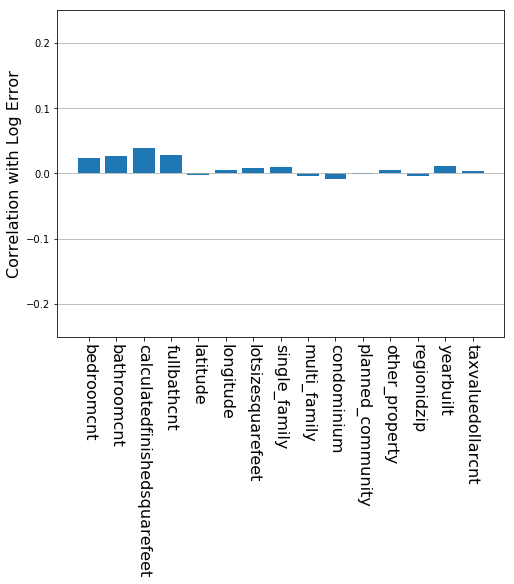

In [15]:
# now bar plot just correlation of logerror against features

print(corr_properties.shape)

fig = plt.figure()
fig.set_size_inches([8,6])
ax = fig.subplots()
ax.bar(range(len(full_df.columns.values) - 1), corr_properties.iloc[-1,0:15])
ax.set_ylim([-0.25,0.25])
ax.set_ylabel('Correlation with Log Error', fontsize=16)
ax.set_xticks(range(len(full_df.columns.values) - 1))
ax.set_xticklabels(full_df.columns.values[0:-1],rotation=-90, fontsize=16)
ax.grid(True,'major','y')

In [16]:
# split sample into training and test sets 
# retain 20% of the properties with sales (34k) as a test dataset, train on 80% (134k)
X_train, X_test, Y_train, Y_test = train_test_split(X_imputed, Y['logerror'], test_size=0.2, shuffle=True)

# Note: for the moment we are not worry about the time dimension of the sales,
# instead just using all of the sales from 2016 and 2017 as both training and validation data

In [17]:
# let's train the gradient boosted tree model's hyperparameters using sklearn's RandomSearchCV capabilities

# define the estimator as GBT
gbt = GradientBoostingRegressor(loss='lad')

# define the hyperparameter we want to search across in random sampling (as in section 2)
param_dist = {'n_estimators' : randint(2, 100), # number of boosting iterations 
              'max_depth' : randint(3, 5), # allow for potentially many (100 splits) in the trees
              'max_features' : [None, 'sqrt'], # allow either any number of features in bagging, or just the sqrt
              'min_samples_split' : randint(2, 11), # controls on splitting and leaves
              'min_samples_leaf' : randint(1, 11),
              'criterion' : ['friedman_mse', 'mse', 'mae']} # vary the scoring method
# random sampling strategy suggested by scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py

# randomly search parameters using my laptop's cores
n_iter_random = 1 # 5 iterations of parameters for each fold 
cv_random = 2 # 5-fold cross validation
gbt_hypertuning = RandomizedSearchCV(estimator=gbt, param_distributions=param_dist, n_iter=n_iter_random,
                               cv=cv_random, random_state=120914, n_jobs=-1, verbose=4, return_train_score=True)

# Fit the random search model for hyperparameter tuning
gbt_hypertuning.fit(X_train, Y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] criterion=friedman_mse, max_depth=4, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=97 
[CV] criterion=friedman_mse, max_depth=4, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=97 
[CV]  criterion=friedman_mse, max_depth=4, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=97, score=0.001733592839479603, total=  21.8s
[CV]  criterion=friedman_mse, max_depth=4, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=97, score=0.0018247662223802585, total=  21.9s


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   22.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   22.3s finished


RandomizedSearchCV(cv=2, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=1, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff1f4ffc2b0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff1f4ffc128>, 'max_features': [None, 'sqrt'], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff1f4ffc9e8>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff1f4ffcb70>

In [18]:
results_df = pd.DataFrame(gbt_hypertuning.cv_results_)
results_df.sort_values('mean_test_score', ascending=False, inplace=True)
results_df.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,21.61474,0.016162,0.238249,0.004038,friedman_mse,4,None,1,6,97,"{'criterion': 'friedman_mse', 'max_depth': 4, ...",0.001734,0.001825,0.001779,0.000046,1,0.008685,0.005909,0.007297,0.001388


In [19]:
# train model using best hyperparameters and whole training dataset

# use the best hyperparameters
best = gbt_hypertuning.best_params_
print(best)
gbt_train = GradientBoostingRegressor(**best)

# train the model
gbt_train.fit(X_train,Y_train)

{'criterion': 'friedman_mse', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 97}


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=97, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [20]:
# evaluate best model on test dataset

# produce predictions 
Y_pred = gbt_train.predict(X_test)

# compute MAE on predictions
MAE = mean_absolute_error(Y_pred, Y_test)
print(MAE)

gbt_train.score(X_test, Y_test, sample_weight=None)

0.06948640910459171


-0.009277276822369009

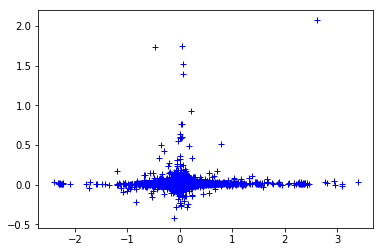

In [21]:
fig, ax = plt.subplots()
ax.plot(Y_test, Y_pred, 'b +')

Text(0.5,0,'Feature Name')

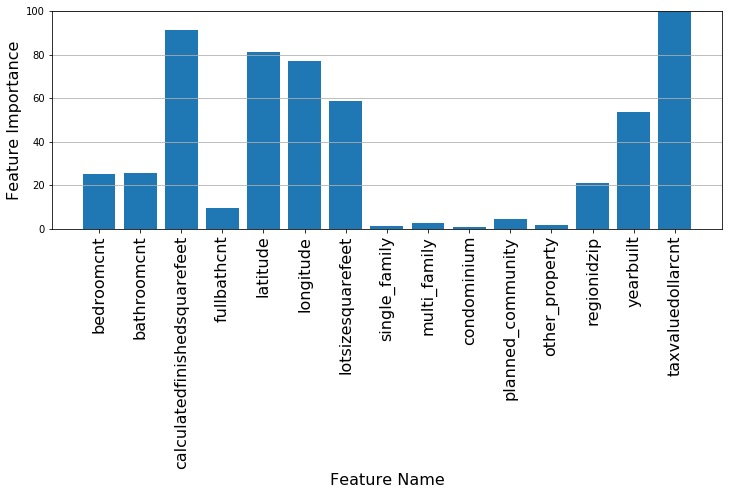

In [22]:
# now extract feature importances and plot
feature_importances = gbt_train.feature_importances_
feature_names = X_imputed.columns.values

fig = plt.figure()
fig.set_size_inches([12,4])
ax = fig.subplots(1)
ax.bar(range(1,len(feature_importances) + 1), 100*feature_importances/max(feature_importances))
ax.set_ylim([0, 100])
ax.set_xticks(range(1,len(feature_importances) + 1))
ax.set_xticklabels(feature_names,FontSize=16, rotation=90)
ax.grid(True,'major','y')
ax.set_ylabel('Feature Importance',FontSize=16)
ax.set_xlabel('Feature Name',FontSize=16)

In [23]:
# in order to make predictions for the full dataset, first load the model columns from the 2016 data

raw_features_in_model = ['parcelid','bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','fullbathcnt',
                         'latitude','longitude','lotsizesquarefeet','propertylandusetypeid',
                         'regionidzip','yearbuilt','taxvaluedollarcnt']

features_full_2016 = pd.read_csv(fname_features_2016, index_col=0, header=0, usecols=raw_features_in_model)

/home/brian/anaconda3/envs/insight/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [24]:
features_full_2016.sample(10)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,regionidzip,yearbuilt,taxvaluedollarcnt
parcelid,,,,,,,,,,,
12524569,4.0,4.0,4420.0,4.0,33780964.0,-118140813.0,4057.0,248.0,96238.0,1926.0,332130.0
12543727,2.0,2.0,1018.0,2.0,33769500.0,-118165000.0,25779.0,266.0,96246.0,1966.0,300893.0
14372336,2.0,3.0,1712.0,2.0,33646351.0,-117705927.0,6360.0,261.0,96962.0,1976.0,581256.0
12893534,2.0,3.0,1660.0,2.0,34080703.0,-117748903.0,7513.0,261.0,96507.0,1947.0,66282.0
13000867,1.0,3.0,1024.0,1.0,34083567.0,-118036876.0,5674.0,261.0,96478.0,1954.0,385000.0
12601859,3.0,2.0,1165.0,3.0,33828900.0,-118330000.0,129089.0,266.0,96161.0,1985.0,315146.0
12197122,1.0,2.0,744.0,1.0,33971536.0,-118270487.0,5104.0,261.0,95984.0,1920.0,137746.0
11100227,3.0,3.0,1576.0,3.0,34234500.0,-118548000.0,238659.0,266.0,96354.0,1979.0,341000.0
17308791,0.0,0.0,1404.0,NaN,34191873.0,-118959757.0,NaN,263.0,96351.0,2006.0,45500.0


In [25]:
# repeat dealing with categorical data and imputation 

# single family homes (most of the dataset)
features_full_2016['single_family'] = [
    1 if val == 261.0 else 0 for val in features_full_2016['propertylandusetypeid']]
# multi-family (duplex/triplex etc.)
features_full_2016['multi_family'] = [
    1 if (val >= 246.0 and val <= 248.0) else 0 for val in features_full_2016['propertylandusetypeid']]
# condos (a lot of these also)
features_full_2016['condominium'] = [
    1 if val == 266.0 else 0 for val in features_full_2016['propertylandusetypeid']]
# planned/cluster/mobile (a few of these)
features_full_2016['planned_community'] = [
    1 if (val == 263.0 or val == 265.0 or val == 269.0) \
    else 0 for val in features_full_2016['propertylandusetypeid']]
# everything else (small number of random unusual residential types and commercial properties)
features_full_2016['other_property'] = [
    1 if val not in [246.0, 247.0, 248.0, 261.0, 263.0, 265.0, 266.0, 
        269.0] else 0 for val in features_full_2016['propertylandusetypeid']]

X_full = features_full_2016[features_in_model[:-1]]
#X.sample(10)
del features_full_2016

# impute using the mean as a simple solution
for col in X_full.columns.values:
    if sum(X_full[col].isna()) > 0: # only apply this to columns with missing data
        imputer.fit(X_full[[col]])
        X_full[col] = imputer.transform(X_full[[col]]).ravel()

In [26]:
# now produce predictions for the full dataset using the trained model
Y_pred_full = gbt_train.predict(X_full)

Y_pred_df = pd.DataFrame({'ParcelId': X_full.index, 'y_pred' : Y_pred_full})

In [ ]:
# write output file for submission to kaggle 

file = open(fname_sub, 'w')
file.write('ParcelId,201610,201611,201612,201710,201711,201712\n')
for i in range(len(Y_pred_df)):
#    print(Y_pred_df.ParcelId[i], Y_pred_df.y_pred.values[i])
    file.write('%u,%4.4f,%4.4f,%4.4f,%4.4f,%4.4f,%4.4f\n' % (
        Y_pred_df.ParcelId[i], 
        Y_pred_df.y_pred.values[i], Y_pred_df.y_pred.values[i], Y_pred_df.y_pred.values[i], 
        Y_pred_df.y_pred.values[i], Y_pred_df.y_pred.values[i], Y_pred_df.y_pred.values[i]))
file.close()